Overwriting existing directory '/home/dan/fiftyone/imagenet-sample'
 100% |████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|  762.4Mb/762.4Mb [18.9s elapsed, 0s remaining, 34.0Mb/s]      
Extracting dataset...
Parsing dataset metadata
Found 1000 samples
Dataset info written to '/home/dan/fiftyone/imagenet-sample/info.json'
Loading existing dataset 'imagenet-sample'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use



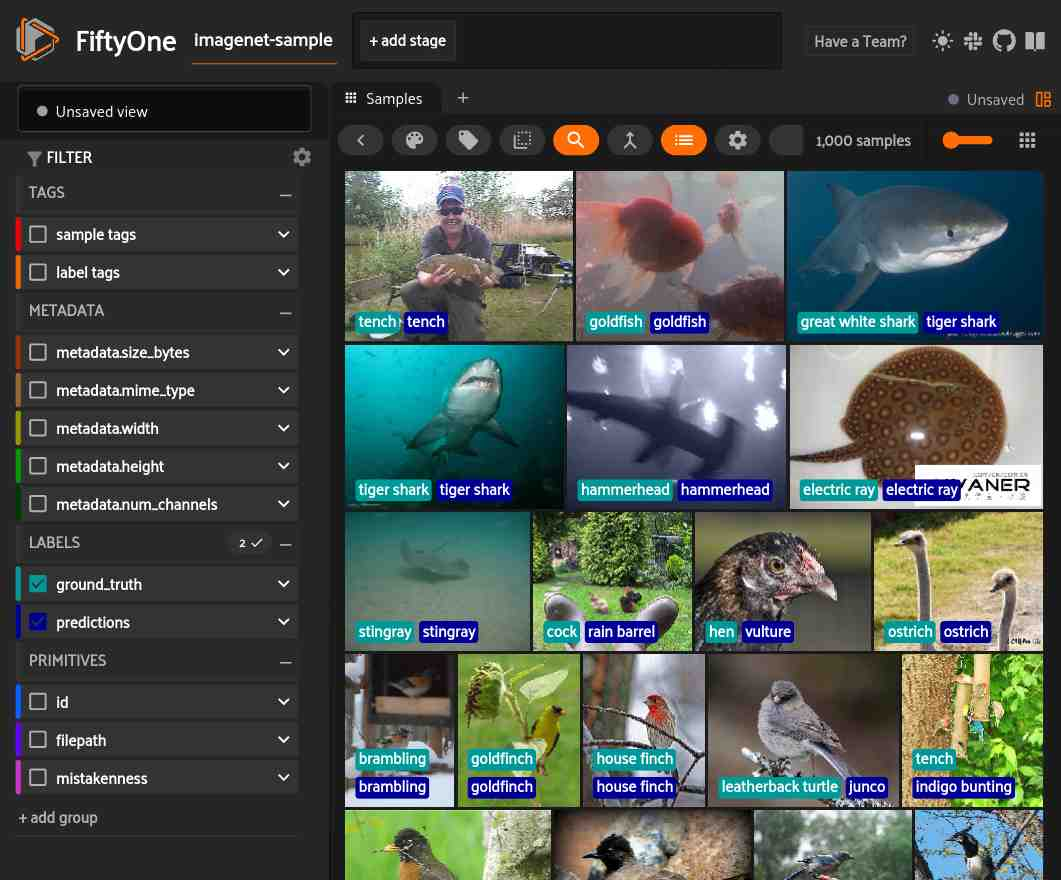

In [3]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("imagenet-sample")

session = fo.launch_app(dataset)

In [ ]:
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")
dataset.apply_model(model, label_field="zoo_predictions")

config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


 100% |███████████████| 1000/1000 [1.5m elapsed, 0s remaining, 10.0 samples/s]      



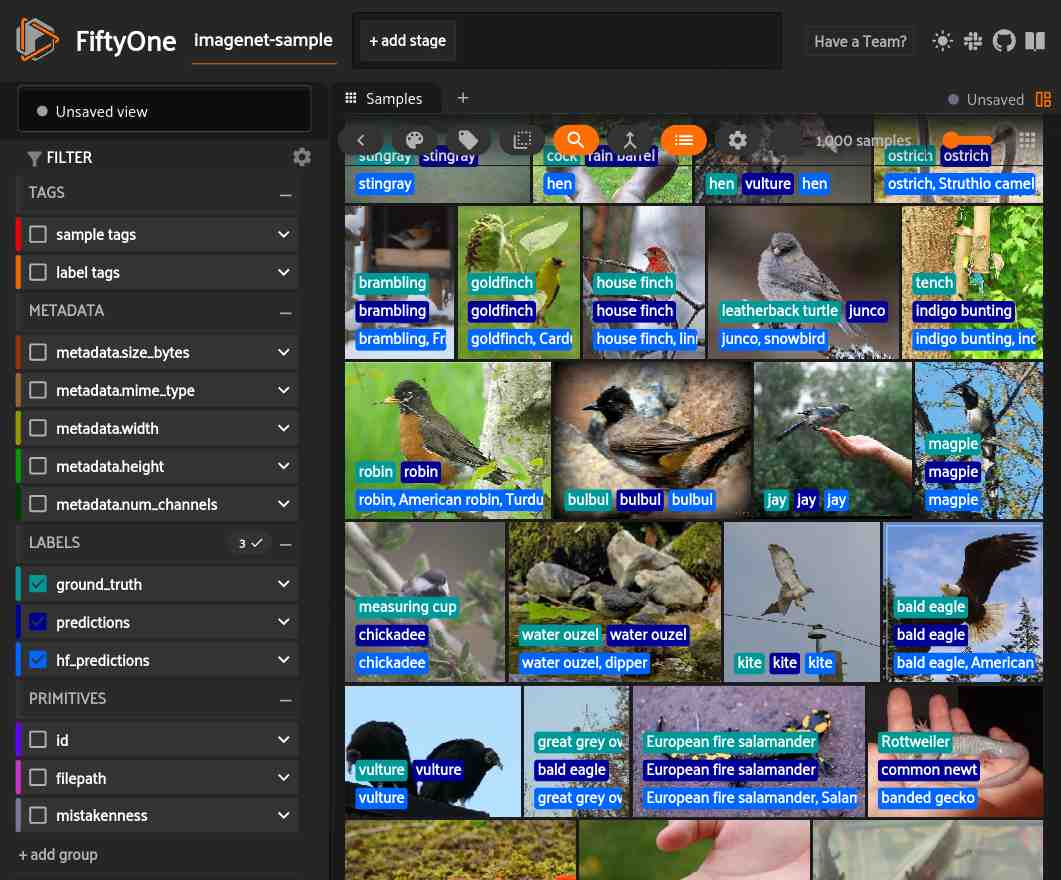

In [4]:
from transformers import BeitForImageClassification

model = BeitForImageClassification.from_pretrained(
    "microsoft/beit-base-patch16-224"
)
dataset.apply_model(model, label_field="hf_predictions")

session.show()

In [5]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/dan/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:15<00:00, 6.66MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
sample = dataset.first()
img = read_image(sample.filepath)


# Step 2: Initialize the inference transforms
preprocess = weights.transforms()


# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

tench: 54.5%


In [11]:
sample["custom_predictions"] = fo.Classification(label=category_name, confidence=score)
sample.save()

print(sample.custom_predictions)

<Classification: {
    'id': '663a8e2e3edd7d34ddb6d43d',
    'tags': [],
    'label': 'tench',
    'confidence': 0.5446103811264038,
    'logits': None,
}>


In [12]:
def add_predictions(dataset, model):
    
    weights = ResNet50_Weights.DEFAULT
    preprocess = weights.transforms()
    
    for sample in dataset:
        
        img = read_image(sample.filepath)

        batch = preprocess(img).unsqueeze(0)

        prediction = model(batch).squeeze(0).softmax(0)
        class_id = prediction.argmax().item()
        score = prediction[class_id].item()
        category_name = weights.meta["categories"][class_id]

        sample["custom_predictions"] = fo.Classification(label=category_name, confidence=score)
        sample.save()


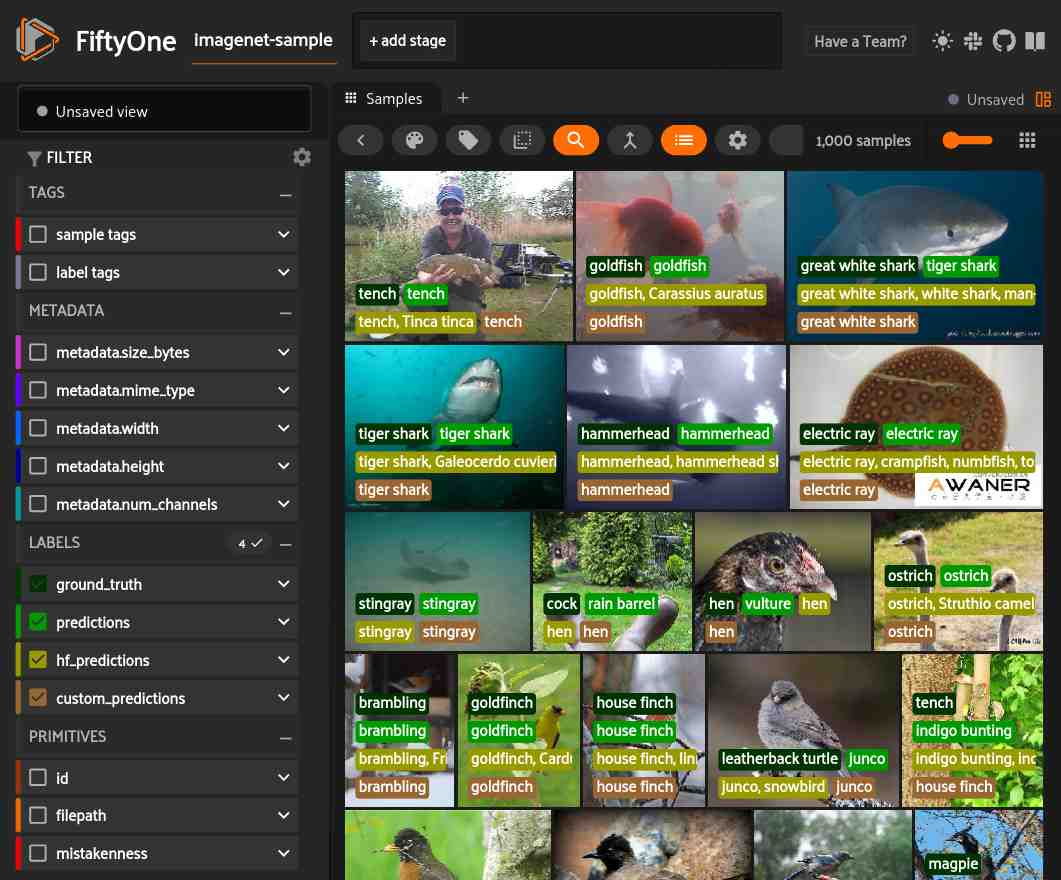

In [13]:
add_predictions(dataset,model)
session.show()